In [1]:
import pandas as pd
from gensim import corpora, models, similarities
from nltk.corpus import stopwords
import re
import numpy as np
from scipy import special
import random
# import matplotlib.pyplot as plt
# %matplotlib inline 

In [2]:
f = '../../data/sherlock_current_wtext.csv'

In [7]:
df = pd.read_csv(f)

In [3]:
def preprocess(df, st):
    #pre-processing
    #input: a slice of the original df
    #output: a list of lists each containing cleaned words from a work
    df = df.astype(str)
    text = df[['Text']]
    text = text.drop_duplicates().Text.str.lower().str.split()
    text_cleaned = []
    for line in text:
        line = [re.sub(r'[^A-Za-z0-9]+', '', str(word)) for word in line]
        line = [word for word in line if len(word) > 1 and not word.isdigit() and word not in st]
        text_cleaned.append(line)
    return text_cleaned

In [4]:
def filter_length(text, word_limit):
    return [line for line in text if len(line) > word_limit]

In [5]:
def create_df_time(df, time):
    return df[df.PublishDate.str[:7] == time]

In [6]:
def create_corpus(sentences):
    id2word = corpora.dictionary.Dictionary(sentences)
    corpus = [id2word.doc2bow(sentence) for sentence in sentences]
    return id2word, corpus

In [10]:
timelist = df.PublishDate.drop_duplicates().tolist()
timelist = [str(i)[:7] for i in timelist]
timelist = sorted(list(set(timelist)))[2:]

In [14]:
st = [line.strip() for line in open('nltk_stopwords', 'r')]

In [ ]:
text = preprocess(df, st)
text = filter_length(text, 500)
id2word = corpora.dictionary.Dictionary(text)
corpus = [id2word.doc2bow(t) for t in text]
lda = models.LdaMulticore(corpus=corpus,id2word=id2word,num_topics=40)

In [19]:
for month in timelist:
    df_ts = create_df_time(df,month)
    text = preprocess(df_ts, st)
    text = filter_length(text, 500)
    with open('./lda_topic40_%s' %month, 'w') as g:
        for i in range(len(text)):
            g.write(str(lda.get_document_topics(id2word.doc2bow(text[i]), minimum_probability = 0)))
            g.write('\n')

In [20]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

In [21]:
def read_gamma(month):
    with open('lda_results/topic40/lda_topic40_%s' %month, 'r') as f:
        gamma = f.readlines()
        for i in range(len(gamma)):
            gamma[i] = gamma[i].replace(')','').replace(']','').strip()
            gamma[i] = [float(v.strip()) for v in gamma[i].split(',') if is_number(v.strip())]
    return np.asarray(gamma)

In [22]:
gamma = read_gamma('2010-08')

In [23]:
print gamma[0]

[  2.77531083e-06   2.77531083e-06   2.77531083e-06   1.06955891e-01
   2.77531083e-06   2.77531083e-06   1.12870451e-02   2.23981754e-01
   1.29678382e-01   2.77531083e-06   2.77531083e-06   2.46551280e-02
   2.77531083e-06   2.77531083e-06   6.81910912e-03   1.11158428e-02
   9.19606420e-04   1.15703183e-02   2.77531083e-06   2.77531083e-06
   2.77531083e-06   2.77531083e-06   2.77531083e-06   2.77531083e-06
   2.77531083e-06   2.77531083e-06   2.77531083e-06   4.63504927e-01
   2.77531083e-06   8.14956840e-04   2.77531083e-06   2.77531083e-06
   2.77531083e-06   2.77531083e-06   2.77531083e-06   8.28394230e-03
   2.77531083e-06   3.38164147e-04   2.77531083e-06   2.77531083e-06]


In [24]:
def JSD(P, Q):
    M = 0.5 * (P + Q)
    return 0.5 * (sum(special.rel_entr(P, M)) + sum(special.rel_entr(Q, M)))

In [25]:
def calculate_monthly_jsd(matrix):
    jsds = []
    for i in range(matrix.shape[0]):
        for j in range(i+1, matrix.shape[0]):
            jsds.append(JSD(matrix[i], matrix[j]))
    return jsds

In [26]:
def bootstrap_resample(jsd_list):
    ave_original = np.average(jsd_list)
    aves = []
    for i in range(1000):
        sample = []
        for i in range(len(jsd_list)):
            sample.append(random.choice(jsd_list))
        aves.append(np.average(sample))
    tail = sorted(aves)[24]
    head = sorted(aves)[975]
    return (ave_original, tail, head)

In [27]:
jsds_timerange = []
for month in timelist:
    gamma = read_gamma(month)
    monthly_jsds = calculate_monthly_jsd(gamma)
    monthly_ave_resampled_jsds = bootstrap_resample(monthly_jsds)
    jsds_timerange.append(monthly_ave_resampled_jsds)


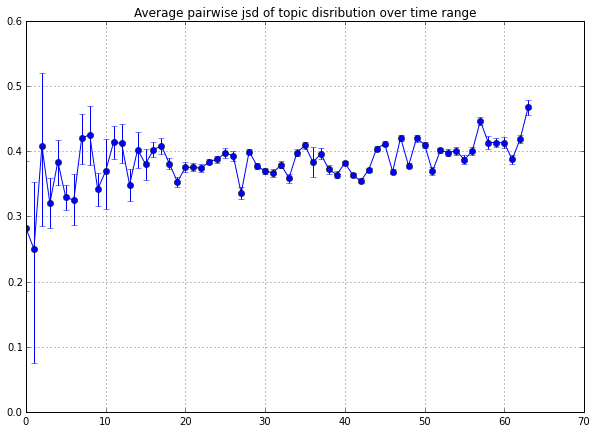

In [6]:
y = [i[0] for i in jsds_timerange]
x = range(len(y))

# example error bar values that vary with x-position
# error = 0.1 + 0.2 * x

# error bar values w/ different -/+ errors
lower_error = [i[0]-i[1] for i in jsds_timerange]
upper_error = [i[2]-i[0] for i in jsds_timerange]
asymmetric_error = [lower_error, upper_error]

fig, ax = plt.subplots(figsize = (10, 7))

ax.errorbar(x, y, yerr=asymmetric_error,marker='o')
ax.set_title('Average pairwise jsd of topic disribution over time range (40 topics)')
# ax.set_yscale('log')
# ax.set_ylim([0.180, 0.225])
plt.grid()
plt.show()
